In [1]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import argparse
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time
import networkx as nx
import random
import math
import cv2
from munkres import Munkres

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# scikit-learn imports
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering, KMeans
import sklearn.metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import confusion_matrix

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [4]:
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def generate_plot_data(n_samples=10000, toPlot=False):
    noise_param = 0.07
    n_samples_one_moon = round(n_samples/3)

    R = 1
    one_circ_x = R * np.cos(np.linspace(0, math.pi, n_samples_one_moon))
    one_circ_y = R * np.sin(np.linspace(0, math.pi, n_samples_one_moon))

    two_circ_x = 1.5 * R * np.cos(np.linspace(math.pi, 2 * math.pi, n_samples_one_moon)) + 1.5
    two_circ_y = 1.5 * R * np.sin(np.linspace(math.pi, 2 * math.pi, n_samples_one_moon)) + 0

    three_circ_x = R * np.cos(np.linspace(0, math.pi, n_samples_one_moon)) + 3
    three_circ_y = R * np.sin(np.linspace(0, math.pi, n_samples_one_moon))

    X1 = np.concatenate((one_circ_x, two_circ_x, three_circ_x), axis=0)
    X2 = np.concatenate((one_circ_y, two_circ_y, three_circ_y), axis=0)
    X =  np.stack((X1, X2), axis=1)

    noise = noise_param * np.random.randn(X.shape[0], X.shape[1])
    X = X + noise
    y = np.concatenate((np.zeros(n_samples_one_moon), np.ones(n_samples_one_moon), 2 * np.ones(n_samples_one_moon)))

    my_X = np.array([[-1.0, 0.0], [0.0, 1.0], [1.0, 0], [0.0, 0.0], [1.5, -1.5], [3.0, 0.0], [2.0, 0.0], [3.0, 1.0], [4.0, 0.0]])
    my_y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

    total_X = np.concatenate([my_X, X])
    total_y = np.concatenate([my_y, y])

    # plot
    if toPlot == True:
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(total_X[:, 0], total_X[:, 1], c=total_y, cmap=cm)
        ax.set_title("3-Moons Dataset")
        ax.grid(True)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.scatter(total_X[9:, 0], total_X[9:, 1], c='white', edgecolor ="lightgray")
        ax.scatter(total_X[0, 0], total_X[0, 1],label='$n_{0}$', marker='o', s = 100)
        ax.scatter(total_X[1, 0], total_X[1, 1], label='$n_{1}$', marker='*', s = 100)
        ax.scatter(total_X[2, 0], total_X[2, 1], label='$n_{2}$', marker='+', s = 100)
        ax.scatter(total_X[3, 0], total_X[3, 1], label='$n_{3}$', marker='x', s = 100)
        ax.scatter(total_X[4, 0], total_X[4, 1], label='$n_{4}$', marker='d', s = 100)
        ax.scatter(total_X[5, 0], total_X[5, 1], label='$n_{5}$', marker='|', s = 100)
        ax.scatter(total_X[6, 0], total_X[6, 1], label='$n_{6}$', marker='p', s = 100)
        ax.scatter(total_X[7, 0], total_X[7, 1], label='$n_{7}$', marker='s', s = 100)
        ax.scatter(total_X[8, 0], total_X[8, 1], label='$n_{8}$', marker='8', s = 100)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
        plt.grid(True)
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.show()
    return total_X, total_y

In [7]:
def createAffinity(data, ms, ms_normal, sigmaFlag):
    '''
    Computes the Affinity matrix
    inputs:
    data:                   array of data featrues
    ms:                     neighbors number per node
    ms_normal:              neighbor for the kernel std. 
    sigmaFlag:              flag for the kernel variance calculation
    
    returns:    
    y:                      the affinity matrix                
    '''
    n = data.shape[0]
    nbrs = NearestNeighbors(n_neighbors=ms, algorithm='kd_tree').fit(data)
    dist, idx = nbrs.kneighbors(data)
    graph_median = np.median(dist)
    dist = torch.Tensor(dist.T)
    idx = torch.Tensor(idx.T)
    id_row = torch.Tensor([range(0, n)])
    id_row = id_row.repeat(ms, 1)
    id_row = id_row.numpy()
    id_col = idx.numpy()

    if sigmaFlag == 0:
        sigma = torch.diag(1. / dist[ms_normal, :])
        W = torch.exp(-(dist @ sigma) ** 2)

    if sigmaFlag == 1:
        sigma = torch.median(dist[ms_normal, :])
        W = torch.exp(-dist ** 2 / (sigma ** 2))

    if sigmaFlag == 2:
        W = torch.exp(-dist ** 2 / (2 * graph_median ** 2))

    if sigmaFlag == 3:
        sigma = 10000
        W = torch.exp(-dist ** 2 / sigma)

    y = torch.sparse_coo_tensor([id_row.flatten(), id_col.flatten()], W.flatten(), (n, n))
    y = y.to_dense()
    y = (y + y.T) / 2
    return y

def ev_calculation(features, classNum, ms, ms_normal, sigmaFlag):
    '''
    Computes the graph Laplacian eigenvectors
    inputs:
    features:               array of data featrues
    classNum:               number of classes
    ms:                     neighbors number per node
    ms_normal:              neighbor for the kernel std. 
    sigmaFlag:              flag for the kernel variance calculation
    
    returns:    
    RCut_EV:                the first K eigenvectors of L/L_N               
    '''
    n = features.size(0)

    W = createAffinity(features, ms, ms_normal, sigmaFlag)
    s0 = torch.sum(W, axis=0)

    # L
    D = torch.diag(s0)
    L = D - W
    S_L, U_L = torch.linalg.eig(L) # return ev with norm 1
    S_L = torch.real(S_L)
    U_L = torch.real(U_L)
    S_L, indices = torch.sort(S_L, dim=0, descending=False, out=None)
    U_L = U_L[:, indices]
    RCut_EV = U_L[:, 1:classNum]
    # RCut_EV = U_L[:, 0:classNum]

    # L_N
    # D_sqrt = torch.diag(1. / torch.sqrt(s0))
    # I = torch.eye(n)
    # N = I - D_sqrt @ W @ D_sqrt
    # S_N, U_N = torch.linalg.eig(N)  # return ev with norm 1
    # S_N = torch.real(S_N)
    # U_N = torch.real(U_N)
    # S_N, indices = torch.sort(S_N, dim=0, descending=False, out=None)
    # U_N = U_N[:, indices]
    # # RCut_EV = U_N[:, 1:classNum]
    # RCut_EV = U_N[:, 0:classNum]
    return RCut_EV


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels


def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix


def get_acc(cluster_assignments, y_true, n_clusters):
    '''
    Computes the accuracy based on the provided kmeans cluster assignments
    and true labels, using the Munkres algorithm
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    y_true = y_true.numpy()
    y_pred, confusion_matrix = get_y_preds(cluster_assignments, y_true, n_clusters)
    # calculate the accuracy
    return np.mean(y_pred == y_true), confusion_matrix

def SpectralClusteringFromEV(ev, true_labels, classNum):
    '''
    performe spectral clutering from the spectral embedding
    inputs:
    ev:                     the eigenvectors of the graph Laplacian
    true_labels:            data true labels
    classNum:               number of classes

    returns:    
    RCut_labels:            spectral clustering assignment 
    model_nmi:              nmi value
    model_acc:              acc value
    '''
    RCut_kmeans = KMeans(n_clusters=classNum, random_state=0).fit(ev)
    RCut_labels = RCut_kmeans.labels_
    model_nmi = normalized_mutual_info_score(true_labels, RCut_labels)
    model_acc, _ = get_acc(RCut_labels, true_labels, classNum)
    return RCut_labels, model_nmi, model_acc

def grassmann(A, B):
    '''
    calcute grassmann distance 
    inputs:
    A, B:                   the matrices for which the distance is checked

    returns:    
    grassmann_val:          grassmann distance between A and B 
    '''
    n, m = A.shape

    A_col_norm = torch.linalg.norm(A, dim=0)
    A_col_norm = 1 / A_col_norm
    A_norm_matrix = torch.tile(A_col_norm, (n, 1))
    A_normalized = A_norm_matrix * A  
    A_normalized = A_normalized.float()

    B_col_norm = torch.linalg.norm(B, dim=0)
    B_col_norm = 1 / B_col_norm
    B_norm_matrix = torch.tile(B_col_norm, (n, 1))
    B_normalized = B_norm_matrix * B  
    B_normalized = B_normalized.float()

    M = A_normalized.T @ B_normalized
    _, s, _ = torch.linalg.svd(M) # return ev with norm 1
    s = 1 - torch.square(s)
    grassmann_val = torch.sum(s)
    return grassmann_val

def get_orthogonality_measure(U, classNum):
    '''
    calcute the orthogonality measure
    inputs:
    U:                      the matrix whose orthogonality is tested
    classNum:               number of classes

    returns:    
    orthogonality_measure:  orthogonality measure 
    '''
    n, m = U.shape
    ev_norm = np.linalg.norm(U, axis=0)
    ev_norm = 1 / ev_norm
    ev_norm_matrix = np.tile(ev_norm, (m, 1))
    orthogonality_matrix = U.T @ U
    orthogonality_matrix = np.multiply(np.multiply(ev_norm_matrix.T, orthogonality_matrix), ev_norm_matrix)

    dim = orthogonality_matrix.shape[0]
    I = np.eye(dim)

    orthogonality_measure = np.linalg.norm(orthogonality_matrix - I)
    return orthogonality_measure

In [8]:
def generateBase(xTrain, yTrain, nodes_indx_list, number_of_sampled_nodes, 
                 anchors_per_class, anchors_idx, classNum,
                 classes, ms, ms_normal, sigmaFlag, device):
    '''
    Sample the refernce set and return its spectral embedding 
    '''
    base_sampled_nodes_indx = random.sample(nodes_indx_list, number_of_sampled_nodes)
    base_sampled_nodes_indx = sorted(
        base_sampled_nodes_indx + [indx for indx in anchors_idx if indx not in base_sampled_nodes_indx])
    inputs = xTrain[base_sampled_nodes_indx, :]
    inputs = torch.tensor(inputs).to(device)

    labels = torch.tensor(yTrain[base_sampled_nodes_indx]).to(device)

    U_sampled_base = ev_calculation(inputs, classNum, ms, ms_normal, sigmaFlag)

    RCut_labels_sampled, model_nmi, model_acc = SpectralClusteringFromEV(U_sampled_base, labels, classNum)
    # print("Base NMI : ", model_nmi)
    # print("Base ACC : ", model_acc)
    return U_sampled_base


def calculateM(U_sampled_test, U_sampled):
    '''
    Calculate alignment transformation between U_sampled_test and U_sampled
    '''
    num_points = U_sampled_test.shape[0]

    n_digits = 4  # number of digits of precision
    U_sampled_test = torch.round(U_sampled_test * 10 ** n_digits) / (10 ** n_digits)
    U_sampled = torch.round(U_sampled * 10 ** n_digits) / (10 ** n_digits)

    pts1 = np.float32(U_sampled_test)  # from
    pts2 = np.float32(U_sampled)  # to

    A = np.concatenate([pts1, np.ones([len(pts1), 1])], axis=1)

    M, _, _, _ = np.linalg.lstsq(A, pts2, rcond=None)
    M = M.T

    return M


def AffineU(pts1, pts2, anchors_num, nPoints, nIter, tol, plotTransforms=False, saveImages=False,
            model_path=None, test_num=None):
    '''
    Calculate the optimal alignment transformation with RANSAC 
    inputs:
    pts1:                   current embedding 
    pts2:                   refernce embedding 
    anchors_num:            anchors number 
    nPoints:                number of anchors with which the transformation is actually calculated
    nIter:                  number of RANSAC iterations
    tol:                    tolerance parameter for RANSAC
    plotTransforms:         flag for printing the transformation
    saveImages:             flag for printing saving  the transformation image 
    model_path:             path for images 
    test_num:               current test number 
       
    returns:    
    bestU:                  pts1 after alignment
    '''
    N = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([N, 1])], axis=1)

    best_inliers_n = 0
    best_inliers = []

    for iter in range(nIter):
        rand_idxs = np.random.choice(np.arange(anchors_num), nPoints, replace=False)
        chosen_p1 = pts1[rand_idxs, :]
        chosen_p2 = pts2[rand_idxs, :]
        chosen_M = calculateM(chosen_p1, chosen_p2)
        chosen_U = chosen_M.dot(hpts1.T)
        chosen_U = torch.tensor(chosen_U.T)

        pts1_anchor = pts1[0:anchors_num]
        pts2_anchor = pts2[0:anchors_num]
        chosen_U_anchor = chosen_U[0:anchors_num]

        L2dists = torch.sqrt(torch.sum((chosen_U_anchor[0:anchors_num] - pts2_anchor[0:anchors_num]) ** 2, 1))
        inliers = (pts1_anchor[L2dists < tol, :], pts2_anchor[L2dists < tol, :])
        n_inliers = torch.sum(L2dists < tol)
        if n_inliers > best_inliers_n:
            best_inliers_n = n_inliers
            best_inliers = inliers

    bestM = calculateM(best_inliers[0], best_inliers[1])
    if plotTransforms:
        cmap = plt.get_cmap('GnBu')
        new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.0, b=0.8),
            cmap(np.linspace(0.0, 0.7, 100)))

        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.matshow(bestM, cmap=new_cmap)
        for (i, j), z in np.ndenumerate(bestM):
            ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', weight='bold')
        plt.grid(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        if saveImages:
            savefig_path = model_path + "/tramsform_test_num_" + str(test_num) + ".png"
            plt.savefig(savefig_path)
        plt.show()

    bestU = bestM.dot(hpts1.T)
    bestU = bestU.T
    return torch.tensor(bestU, dtype=float)

In [9]:
class EvModule(nn.Module):
    '''
    BASiS model  
    '''
    def __init__(self, n_features=2, projection_dim=1):
        super(EvModule, self).__init__()

        self.n_features = n_features
        self.projection_dim = projection_dim

        self.model = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.projection_dim),
        )

    def forward(self, x):
        return self.model(x)


def train_model(xTrain, yTrain, xValid, yValid, classes, anchors_per_class, 
                anchors_num, number_of_sampled_nodes, ms,
                ms_normal, sigmaFlag, ransac_nPoints, ransac_nIter, 
                ransac_tol, iter_num, device):
    '''
    Train BASiS model
    inputs:
    xTrain:                   training features 
    yTrain:                   training labels 
    xValid:                   validation features 
    yTrain:                   validation labels 
    classes:                  the problem classes 
    anchors_per_class:        number of anchors per class
    anchors_num:              anchors number 
    number_of_sampled_nodes:  batch size 
    ms:                       neighbors number per node
    ms_normal:                neighbor for the kernel std. 
    sigmaFlag:                flag for the kernel variance calculation
    ransac_nPoints:           number of anchors with which the transformation is actually calculated
    ransac_nIter:             number of RANSAC iterations
    ransac_tol:               tolerance parameter for RANSAC
    iter_num:                 number of training  iterations
    device:                   device id 
       
    returns:    
    model:                    trained BASiS model 
    U_sampled_base:           refernce spectral embedding 
    '''            
    nodes_num, node_dim = xTrain.shape
    classNum = len(classes)

    learning_rate = 1e-4
    n_features = node_dim
    projection_dim = classNum - 1

    # create model
    model = EvModule(n_features, projection_dim)

    # loss criterion
    criterion = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    nodes_indx_list = range(0, nodes_num)
    anchors_idx = range(0, anchors_num)
    U_sampled_base = generateBase(xTrain, yTrain, nodes_indx_list, number_of_sampled_nodes, anchors_per_class,
                                  anchors_idx, classNum, classes, ms, ms_normal, sigmaFlag, device)

    for iter in range(1, iter_num + 1):
        model.train()  # put in training mode

        sampled_nodes_indx = random.sample(nodes_indx_list, number_of_sampled_nodes)
        sampled_nodes_indx = sorted(
            sampled_nodes_indx + [indx for indx in anchors_idx if indx not in sampled_nodes_indx])

        inputs = xTrain[sampled_nodes_indx, :]
        inputs = torch.tensor(inputs).to(device)

        U_sampled = ev_calculation(inputs, classNum, ms, ms_normal, sigmaFlag)
        U_sampled = AffineU(U_sampled, U_sampled_base, anchors_num, ransac_nPoints, ransac_nIter, ransac_tol)

        outputs = model(inputs.float()) 
        loss = criterion(outputs, U_sampled.float()) 

        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step()  

    return model, U_sampled_base


def modelEvaluataion(model, xTest, yTest, U_sampled_base, classes, 
                     ms, ms_normal, sigmaFlag, anchors_num,
                     ransac_nPoints, ransac_nIter, ransac_tol):
    '''
    Evaluate BASiS model performance 
    inputs:
    model:                    trained BASiS model
    xTest:                    test set features 
    yTest:                    test set labels 
    U_sampled_base:           refernce spectral embedding 
    classes:                  the problem classes 
    ms:                       neighbors number per node
    ms_normal:                neighbor for the kernel std. 
    sigmaFlag:                flag for the kernel variance calculation
    anchors_num:              anchors number 
    ransac_nPoints:           number of anchors with which the transformation is actually calculated
    ransac_nIter:             number of RANSAC iterations
       
    returns:    
    model_nmi:                nmi 
    model_acc:                acc
    model_grassmann:          grassmann distance 
    model_orthogonality:      orthogonality measure
    '''            
    model.eval()

    classNum = len(classes)

    inputs = torch.tensor(xTest)
    labels = torch.tensor(yTest)
    with torch.no_grad():
        outputs = model(inputs.float())

    RCut_labels, model_nmi, model_acc = SpectralClusteringFromEV(outputs.detach(), labels, classNum)

    U_test = ev_calculation(inputs, classNum, ms, ms_normal, sigmaFlag)
    U_test = AffineU(U_test, U_sampled_base, anchors_num, ransac_nPoints, ransac_nIter, ransac_tol)
    model_grassmann = grassmann(outputs.detach(), U_test)

    model_orthogonality = get_orthogonality_measure(outputs, classNum)

    return model_nmi, model_acc, model_grassmann, model_orthogonality

In [10]:
def heatmap_with_data(model, X_data, y_data):
    model.eval()  # put in evaluation mode

    y, x = torch.meshgrid(torch.linspace(-2.0, 1.5, 1000), torch.linspace(-1.5, 4.5, 1000))
    x_flaten = x.flatten()
    y_flaten = y.flatten()
    x0 = x_flaten.reshape(-1, 1)
    x1 = y_flaten.reshape(-1, 1)
    inputs = torch.cat((x0, x1), 1)

    outputs_sum = model(inputs.float())
    outputs_sum1 = outputs_sum[:, 0]
    outputs_sum2 = outputs_sum[:, 1]

    z1 = outputs_sum1.reshape((x.shape))
    z1_min, z1_max = torch.min(z1).min(), torch.max(z1).max()
    z1 = (z1-z1_min)/(z1_max-z1_min)

    z2 = outputs_sum2.reshape((x.shape))
    z2_min, z2_max = torch.min(z2).min(), torch.max(z2).max()
    z2 = (z2-z2_min)/(z2_max-z2_min)
    z3 = torch.ones(x.shape) * 0.2
    z = torch.stack((z1, z2, z3), dim=2)
    print(z.shape)

    x = x.numpy()
    y = y.numpy()
    z = z.detach().numpy() 

    mesh_rgb = z[:, :-1, :]
    print(mesh_rgb.shape)
    colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)

    colorTuple = np.insert(colorTuple,3,1.0,axis=1)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    c = ax.pcolormesh(x, y, z[:,:,0], color=colorTuple)
    c.set_array(None)
    ax.scatter(X_data[:, 0], X_data[:, 1],facecolors='none', edgecolor ="black", alpha=0.3)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.tight_layout()
    plt.axis('off')
    plt.show()


    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    c = ax.pcolormesh(x, y, z[:,:,0], color=colorTuple)
    c.set_array(None)
    ax.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=cm)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.tight_layout()
    plt.axis('off')
    plt.show()

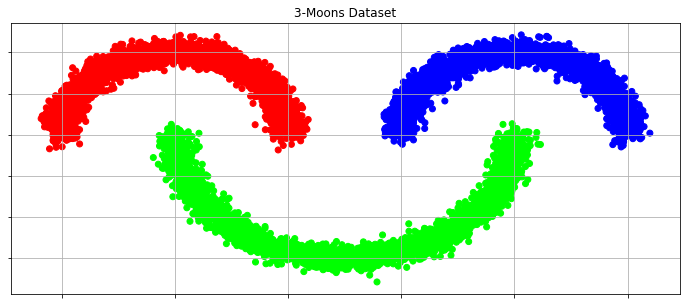

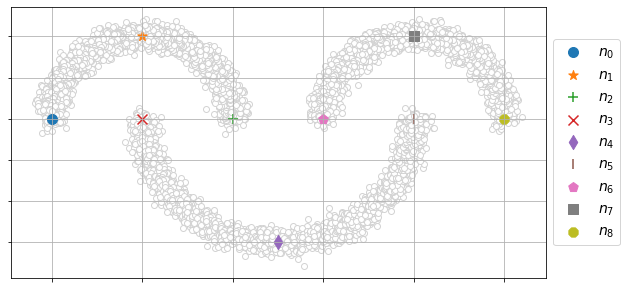

In [11]:
n_samples=10000
classes = ('0', '1', '2')
classNum = len(classes)
anchors_per_class = 3
anchors_num = classNum * anchors_per_class
number_of_sampled_nodes = 256 #"batch size"


n_samples_generaor = n_samples-anchors_num
X, y = generate_plot_data(n_samples_generaor, toPlot=True)
nodes_num = len(y)

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(X[anchors_num:, :], y[anchors_num:], test_size = 0.2, random_state = 0)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size = 0.2, random_state = 0)

xTrain = np.concatenate([X[0:anchors_num, :], xTrain])
yTrain = np.concatenate([y[0:anchors_num], yTrain])

xValid = np.concatenate([X[0:anchors_num, :], xValid])
yValid = np.concatenate([y[0:anchors_num], yValid])

xTest = np.concatenate([X[0:anchors_num, :], xTest])
yTest = np.concatenate([y[0:anchors_num], yTest])

print('xTrain shape:')
print(xTrain.shape)
print('xValid shape:')
print(xValid.shape)
print('xTest shape:')
print(xTest.shape)

xTrain shape:
(6402, 2)
xValid shape:
(1608, 2)
xTest shape:
(2007, 2)


In [13]:
ms = 20
ms_normal = None
sigmaFlag = 1
ransac_nPoints = 5
ransac_nIter = 100
ransac_tol = 0.01
iter_num = 1000

model, U_sampled_base = train_model(xTrain, yTrain, xValid, yValid, classes, anchors_per_class, 
                                    anchors_num, number_of_sampled_nodes, ms,
                                    ms_normal, sigmaFlag, ransac_nPoints, ransac_nIter, 
                                    ransac_tol, iter_num, device)

In [14]:
nmi, acc, grassmann, orthogonality = modelEvaluataion(model, xTest, yTest, U_sampled_base, classes, ms,
                                                          ms_normal, sigmaFlag, anchors_num,
                                                          ransac_nPoints, ransac_nIter, ransac_tol)
print("---------Test Eval -----------")
print("Test NMI: ", nmi)
print("Test ACC: ", acc)
print("Test Grassmann: ", grassmann)
print("Test Orthogonality: ", orthogonality)

---------Test Eval -----------
Test NMI:  0.9965971737072471
Test ACC:  0.9995017438963627
Test Grassmann:  tensor(0.0041)
Test Orthogonality:  0.041624253931694055


torch.Size([1000, 1000, 3])
(1000, 999, 3)


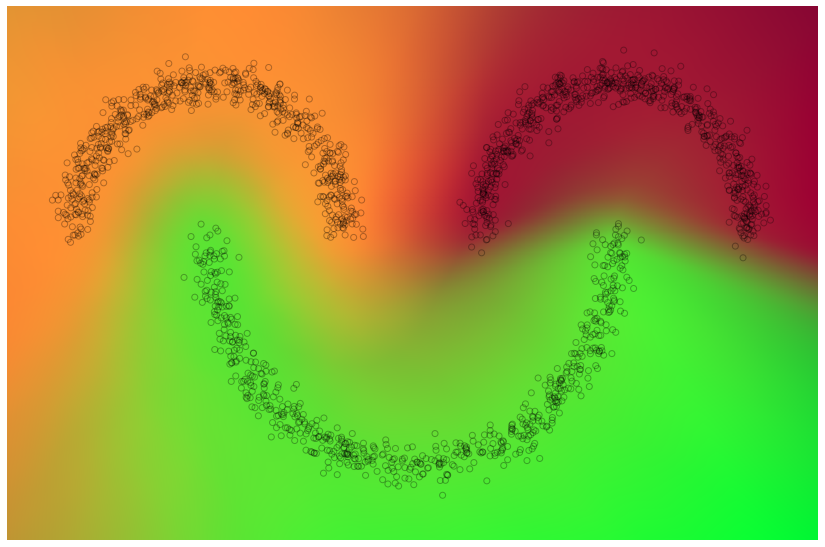

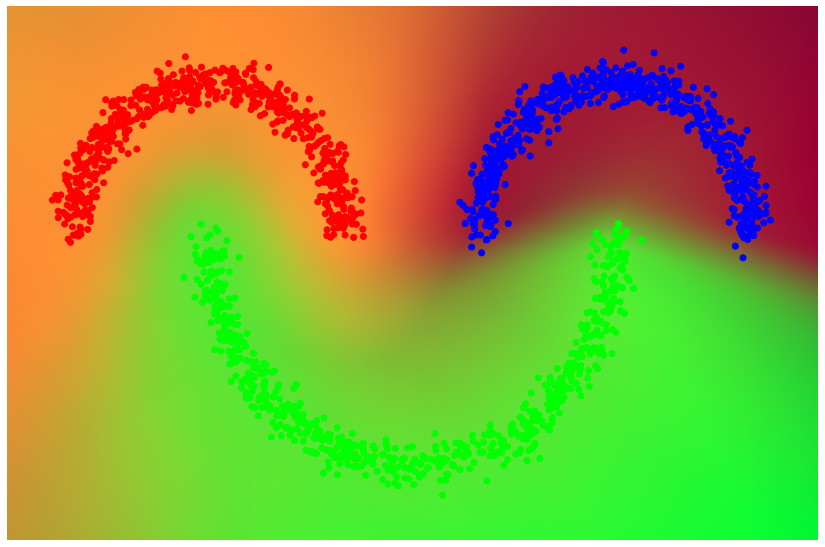

In [15]:
heatmap_with_data(model, xTest, yTest)